  
# Servicios distribuidos
+ **Felix García Carballeira y Alejandro Calderón Mateos**
+ [![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-blue.svg)](https://github.com/acaldero/uc3m_sd/blob/main/LICENSE)


## Contenidos

 * [Sincronización en sistemas distribuidos](#Sincronizaci%C3%B3n-en-sistemas-distribuidos)
 * [Relojes físicos](#Relojes-físicos)
 * [Relojes lógicos](#Relojes-lógicos)
 * [Exclusión mutua distribuida](#Exclusión-mutua-distribuida)
 * [Algoritmos de elección](#Algoritmos-de-elección)
 * [Comunicación multicast](#Comunicación-multicast)
 * [Problemas de consenso](#Problemas-de-consenso)
 * [Servicio de nombres](#Servicio-de-nombres)



## Sincronización en sistemas distribuidos

 * **Más compleja** que en los centralizados ya que usan algoritmos distribuidos
* Los **algoritmos distribuidos** deben tener las siguientes propiedades:
  * La **información relevante se distribuye** entre varios procesos en computadores distintos.
  * Los procesos **toman las decisiones** sólo en base a la **información local**.
  * Debe evitarse un punto único de fallo.
  * **No existe un reloj común**.

### Modelo del sistema distribuido

 * Procesos secuenciales {P<sub>1</sub>, P<sub>2</sub>, ...P<sub>n</sub>} y canales de comunicación
 * Eventos en P<sub>i</sub>
    * E<sub>i</sub> = {e<sub>i1</sub>, e<sub>i2</sub>, ...e<sub>in</sub>}
    * Historia(P<sub>i</sub>) = h<sub>i</sub> =  <e<sub>i0</sub>, e<sub>i1</sub>, e<sub>i2</sub>, ... > donde  e<sub>ik</sub>  ->  e<sub>i(k+1)</sub>
  * Tipos de eventos:
     * Internos (cambios en el estado de un proceso)
     * Comunicación:
        * Envío
        * Recepción
           * e<sub>02</sub>  ->  e<sub>12</sub>
  * Diagramas espacio-tiempo:  
     ![Ejemplo de diagrama de eventos](./ds/ds_diagrama_eventos.svg)


### Modelos síncronos y asíncronos

 * Sistemas distribuidos **asíncronos**:
    * **No hay un reloj común**
    * No hacen ninguna suposición sobre las velocidades relativas de los procesos.
    * Los canales son fiables pero no existe un límite a la entrega de mensajes
    * La comunicación entre procesos es la única forma de sincronización
 * Sistemas  síncronos:
    * Hay una perfecta **sincronización**
    * Hay límites en las latencias de comunicación
    * Los sistemas del mundo real no son síncronos

### Entrega de mensajes en Internet

 * Internet se basa en una red de conmutación de paquetes, donde los paquetes se pueden perder y las copias de mensajes, colas y retardos en la red hace que los tiempos de comunicación no sean predecibles y no estén acotados
 * Internet no usa el concepto de redes de conmutación de circuitos donde sí es predecible y el ancho de banda es asignado estáticamente
 * En Internet el ancho de banda se asigna dinámicamente

### Tiempo en sistemas distribuidos

 * Dificultades en el diseño de aplicaciones distribuidas:
   * Paralelismo entre los procesadores
   * Velocidades arbitrarias de procesadores
   * No determinismo en el retardo de los mensajes. Fallos
   * **Ausencia de tiempo global**

+ Marcas de tiempo (*timestamps*):
  + Relojes físicos
  + Relojes lógicos



## Relojes físicos 

* Para ordenar dos eventos de un proceso basta con asignarles una **marca de tiempo**
* Para un instante físico **t**:
  * H<sub>i</sub>(t): valor del reloj **hardware** (oscilador)
  * C<sub>i</sub>(t): valor del reloj **software** (generado por el sistema operativo):
    * C<sub>i</sub>(t) = a * H<sub>i</sub>(t) + b
       * Ej: cantidad de milisegundos o nanosegundos transcurridos desde una fecha de referencia
    * Resolución del reloj: periodo entre actualizaciones de C<sub>i</sub>(t)
       * Determina la ordenación de eventos
* Dos relojes en dos computadores diferentes dan medidas distintas
  * Necesidad de **sincronizar relojes físicos** de un sistema distribuido

### Tiempo del sistema (Linux)

* Uso de la función ```clock_gettime``` y la estructura ```struct timespec``` :
  ```c
   struct  timespec {
      time_t  tv_sec;  /* seconds */
      long    tv_nsec; /* nanoseconds */
   } ;

   int clock_gettime (clockid_t         clk_id, 
                      struct timespec * tp);
  ```

* La función ```clock_gettime```:
  * Devuelve el número de segundos  transcurridos  **desde 1 de Enero de 1970** y el número de nanosegundos dentro del actual segundo
  * Valores posibles para ```clk_id```:
     * **CLOCK_REALTIME**: Reloj del sistema. Este reloj puede sufrir ajustes para corregir la fecha.
     * **CLOCK_MONOTONIC**: Igual que CLOCK_REALTIME pero no se realizan ajustes, por tanto su cuenta es creciente sin saltos bruscos. Útil para medir duraciones de eventos

+ Ejemplo de uso de la función ```clock_gettime```:
  ```c
    /* 1/ Medición antes y después */
    struct timespec  T_ini, T_fin ;
    clock_gettime(CLOCK_MONOTONIC , &T_ini);
    /* <tarea a medir> */
    clock_gettime(CLOCK_MONOTONIC , &T_fin);
  
    /* 2/ Cálculo de diferencia de tiempos */
    double A1, A2, Tiempo ;
    A1 = (T_fin.tv_sec  - T_ini.tv_sec);
    A2 = (T_fin.tv_nsec - T_ini.tv_nsec) / (double)1000000000;
    Tiempo = A1 + A2;
    printf("Tiempo en segundos = %lf\n", Tiempo);
  ```


### Sincronización de relojes físicos

* Los computadores de un **sistema distribuido** poseen **relojes** que **no están sincronizados** (**derivas**)
  * Importante asegurar una correcta sincronización:
    * En **aplicaciones de tiempo real**
    * Ordenación natural de eventos distribuidos (fechas de ficheros)
    * **Análisis de rendimiento**
* Sincronización:
  * Tradicionalmente se han empleado protocolos de sincronización que intercambian mensajes
  * Actualmente se puede mejorar mediante GPS:
    * Los computadores de un sistema poseen todos un GPS
    * Uno o dos computadores utilizan un GPS y el resto se sincroniza mediante protocolos clásicos

### Sincronización externa versus interna

* **D**: Cota máxima de sincronización
* **S**: fuente del tiempo UTC, t
   * UTC: Estándar de tiempo que regula los relojes y el tiempo en el mundo
* **Sincronización  externa**:
   * Los relojes están sincronizados si **|S(t) - C<sub>i</sub>(t)| < D**
   * Los relojes se consideran sincronizados dentro de D
* **Sincronización interna** entre los relojes de los computadores de un sistema distribuido:
   * Los relojes están sincronizados si **|C<sub>i</sub>(t) - C<sub>j</sub>(t)| < D**
   * Dados dos eventos de dos computadores se puede establecer su orden en función de sus relojes si están sincronizados
* Sincronización externa -> sincronización interna (ok sí) pero <br>Sincronización externa <-/- sincronización interna (ko no solo sí)

### Métodos de sincronización de relojes

 * Sincronización en un sistema síncrono
 * Algoritmo de Cristian
 * Algoritmo de Berkeley
 * Network time protocol



#### Sincronización en un sistema síncrono

* **P1** envía el valor de su reloj local t a **P2**:
   * P2 puede actualizar su reloj al valor **t + T<sub>transmit</sub>  si T<sub>transmit</sub>** es el tiempo que lleva enviar un mensaje
   * Sin embargo, T<sub>transmit</sub>  puede desconocerse
     * Se compite por el uso de la red
     * Congestión de la red
* En un **sistema síncrono** se conoce el tiempo mínimo y máximo de transmisión de un mensaje
* u = (max - min)
   * Si P2 fija su reloj al valor t + (max+min)/2, entonces la deriva máxima es <= u/2
   * El problema es que en un sistema asíncrono T<sub>transmit</sub>  no está acotado



#### Algoritmo de Cristian
![Algoritmo de Cristian](./ds/ds_rf_cristian.svg)

* El cliente realiza una petición para obtener el tiempo
* El servidor responde con el tiempo de su reloj (T<sub>s</sub>)
* El cliente actualiza su reloj a tiempo T<sub>s</sub> +  (T<sub>1</sub> - T<sub>0</sub>) / 2
* Para mejorar la precisión se pueden hacer varias mediciones y descartar cualquiera en la que T<sub>1</sub> - T<sub>0</sub> exceda de un límite
* Precisión del resultado = +/-  (T<sub>1</sub> - T<sub>0</sub>) / 2

##### Mejorando la precisión

* Min: tiempo mínimo de transmisión de un mensaje
* El valor que obtiene el servidor T<sub>s</sub> se encuentra en el intervalo [T\'<sub>s</sub>, T\'\'<sub>s</sub>] = [T<sub>1</sub> + Min, T<sub>2</sub> - Min]
* La precisión del resultado en este caso es: +/- (T<sub>1</sub> - T<sub>0</sub>) / 2 - T<sub>min</sub>



##### Simulación del Algoritmo de Cristian en Python

Programa generado con ChatGPT 5 con el siguiente prompt:
"programa en Python que se puede ejecutar en jupyter notebook y que permite visualizar cómo funciona el algoritmo de ajuste de reloj de Cristian"


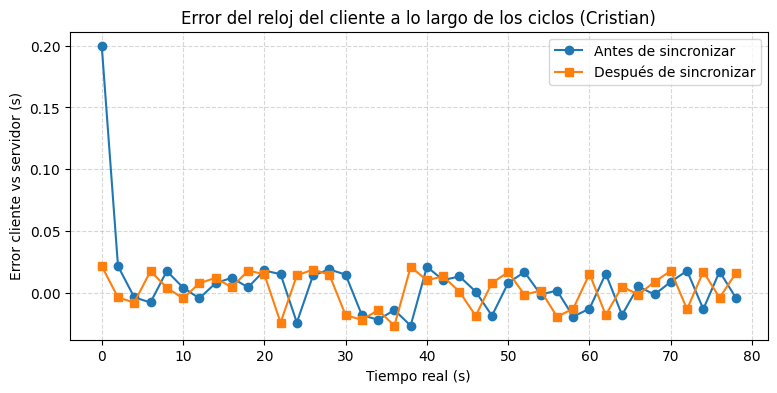

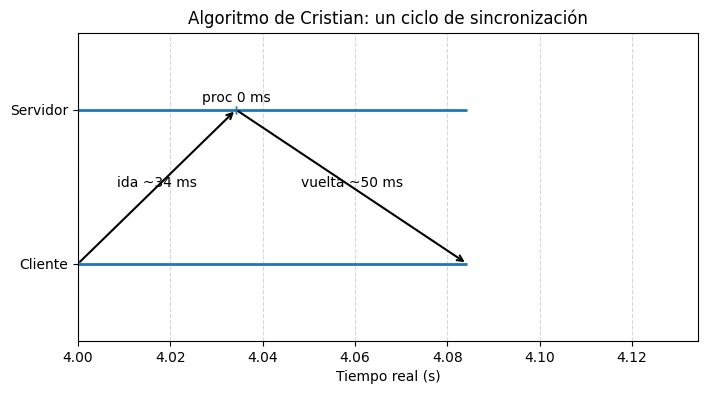

MAE antes: 17.36 ms | MAE después: 12.75 ms


In [29]:
!pip install matplotlib numpy

# --- Cristian: simulación y visualización en Jupyter ---

import math
import random
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

# Para reproducibilidad (opcional)
random.seed(7)
np.random.seed(7)

# ---------------------------
# Modelos de reloj y servidor
# ---------------------------

@dataclass
class Clock:
    """
    Reloj con deriva (ppm) respecto al tiempo 'real' del sistema de simulación.
    deriva_ppm: +10 significa que corre 10 microsegundos de más por segundo (~+0.001%).
    """
    deriva_ppm: float = 0.0
    offset_s: float = 0.0  # offset inicial frente al tiempo real (segundos)

    def now(self, t_real_s: float) -> float:
        # Escala por deriva y suma offset
        escala = 1.0 + self.deriva_ppm * 1e-6
        return self.offset_s + t_real_s * escala

    def set_time(self, t_real_s: float, nuevo_valor: float):
        """
        Fuerza el reloj a un valor dado en el instante real t_real_s
        ajustando el offset interno (no cambia la deriva).
        """
        escala = 1.0 + self.deriva_ppm * 1e-6
        self.offset_s = nuevo_valor - t_real_s * escala

    def error_vs(self, t_real_s: float, referencia_fn) -> float:
        """Error = reloj_cliente(t) - referencia(t). referencia_fn(t)->segundos."""
        return self.now(t_real_s) - referencia_fn(t_real_s)


@dataclass
class Server:
    clock: Clock

    def time(self, t_real_s: float) -> float:
        return self.clock.now(t_real_s)


@dataclass
class Client:
    clock: Clock

    def time(self, t_real_s: float) -> float:
        return self.clock.now(t_real_s)

    def apply_cristian(self, t_real_recv: float, t_srv_reported: float, rtt_s: float, t_proc_s: float = 0.0):
        """
        Algoritmo de Cristian:
        tiempo_estimado_servidor_en_llegada = t_srv_reported + t_proc_s + (rtt_s - t_proc_s)/2
        (si t_proc_s ~ 0, queda t_srv_reported + rtt/2)
        """
        # Tiempo que estimamos que marca el servidor cuando llega la respuesta
        t_srv_est_al_recibir = t_srv_reported + (rtt_s - t_proc_s) / 2.0
        # Fijamos el reloj local a ese instante
        self.clock.set_time(t_real_recv, t_srv_est_al_recibir)


# ---------------------------
# Retardos de red
# ---------------------------

def make_network_delay_sampler(mean_ms=50, jitter_ms=20, min_ms=1):
    """
    Devuelve una función que genera retardos no negativos con distribución 'clipped normal'.
    """
    def sampler():
        d = np.random.normal(loc=mean_ms, scale=jitter_ms)
        return max(min_ms, float(d)) / 1000.0
    return sampler

def sincronizacion_cristian_round(server, client, t_real_inicio_s, delay_sampler, t_proc_s=0.0):
    """
    Simula un REQUEST (cliente->servidor) y un RESPONSE (servidor->cliente).
    Devuelve diccionario con marcas temporales y estimaciones.
    """
    # Cliente envía petición
    t0_real_send = t_real_inicio_s
    t0_cli = client.time(t0_real_send)

    # Viaje ida
    d1 = delay_sampler()
    t1_real_arrive_srv = t0_real_send + d1

    # Servidor procesa y responde
    t_srv_on_recv = server.time(t1_real_arrive_srv)
    t2_real_send_srv = t1_real_arrive_srv + t_proc_s
    t_srv_on_send = server.time(t2_real_send_srv)

    # Viaje vuelta
    d2 = delay_sampler()
    t3_real_recv_cli = t2_real_send_srv + d2
    t3_cli_before_adjust = client.time(t3_real_recv_cli)

    # Round-trip time real (desconocido para el cliente)
    rtt_real = (t3_real_recv_cli - t0_real_send)

    # El cliente estima RTT en su propio reloj
    rtt_estimado_cli = t3_cli_before_adjust - t0_cli

    # Ajuste Cristian
    client.apply_cristian(
        t_real_recv=t3_real_recv_cli,
        t_srv_reported=t_srv_on_send,
        rtt_s=rtt_estimado_cli,
        t_proc_s=t_proc_s
    )
    t3_cli_after_adjust = client.time(t3_real_recv_cli)

    return {
        "t0_real_send": t0_real_send,
        "t1_real_arrive_srv": t1_real_arrive_srv,
        "t2_real_send_srv": t2_real_send_srv,
        "t3_real_recv_cli": t3_real_recv_cli,
        "d1": d1, "d2": d2, "t_proc": t_proc_s,
        "t0_cli": t0_cli,
        "t3_cli_before": t3_cli_before_adjust,
        "t3_cli_after": t3_cli_after_adjust,
        "t_srv_on_send": t_srv_on_send,
        "rtt_real": rtt_real,
        "rtt_estimado_cli": rtt_estimado_cli,
    }

def dibujar_round(round_data):
    """Dibuja un diagrama temporal del intercambio: Cliente ---- Servidor"""
    t0 = round_data["t0_real_send"]
    t1 = round_data["t1_real_arrive_srv"]
    t2 = round_data["t2_real_send_srv"]
    t3 = round_data["t3_real_recv_cli"]
    d1 = round_data["d1"]
    d2 = round_data["d2"]
    t_proc = round_data["t_proc"]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hlines(1, t0, t3, linewidth=2)  # Servidor
    ax.hlines(0, t0, t3, linewidth=2)  # Cliente
    ax.annotate("", xy=(t1,1), xytext=(t0,0), arrowprops=dict(arrowstyle="->", lw=1.5))
    ax.annotate("", xy=(t3,0), xytext=(t2,1), arrowprops=dict(arrowstyle="->", lw=1.5))
    ax.plot([t1, t2], [1,1], marker="|", linewidth=4)
    ax.text((t0+t1)/2, 0.5, f"ida ~{d1*1000:.0f} ms", ha="center")
    ax.text((t2+t3)/2, 0.5, f"vuelta ~{d2*1000:.0f} ms", ha="center")
    ax.text((t1+t2)/2, 1.05, f"proc {t_proc*1000:.0f} ms", ha="center")
    ax.set_yticks([0,1])
    ax.set_yticklabels(["Cliente","Servidor"])
    ax.set_xlabel("Tiempo real (s)")
    ax.set_title("Algoritmo de Cristian: un ciclo de sincronización")
    ax.set_xlim(t0, t3 + max(0.05, 0.2*(t3-t0)))
    ax.set_ylim(-0.5, 1.5)
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.show()


def simular_cristian(
    n_rounds=50,
    intervalo_round_s=2.0,
    deriva_cliente_ppm=30.0,
    deriva_servidor_ppm=0.0,
    offset_inicial_cliente_s=0.2,
    delay_mean_ms=50,
    delay_jitter_ms=20,
    t_proc_s=0.0,
    mostrar_diagrama_del_round=0
):
    server = Server(Clock(deriva_ppm=deriva_servidor_ppm, offset_s=0.0))
    client = Client(Clock(deriva_ppm=deriva_cliente_ppm, offset_s=offset_inicial_cliente_s))

    t_real_hist = []
    error_hist_antes = []
    error_hist_despues = []

    delay_sampler = make_network_delay_sampler(delay_mean_ms, delay_jitter_ms)
    t_real = 0.0
    round_guardado = None

    for r in range(n_rounds):
        err_antes = client.clock.error_vs(t_real, server.clock.now)
        t_real_hist.append(t_real)
        error_hist_antes.append(err_antes)

        data = sincronizacion_cristian_round(server, client, t_real, delay_sampler, t_proc_s)
        if mostrar_diagrama_del_round is not None and r == mostrar_diagrama_del_round:
            round_guardado = data

        err_despues = client.clock.error_vs(t_real, server.clock.now)
        error_hist_despues.append(err_despues)
        t_real += intervalo_round_s

    fig1, ax1 = plt.subplots(figsize=(9,4))
    ax1.plot(t_real_hist, error_hist_antes, marker="o", label="Antes de sincronizar")
    ax1.plot(t_real_hist, error_hist_despues, marker="s", label="Después de sincronizar")
    ax1.set_xlabel("Tiempo real (s)")
    ax1.set_ylabel("Error cliente vs servidor (s)")
    ax1.set_title("Error del reloj del cliente a lo largo de los ciclos (Cristian)")
    ax1.grid(True, linestyle="--", alpha=0.5)
    ax1.legend()
    plt.show()

    if round_guardado is not None:
        dibujar_round(round_guardado)

    mae_antes = float(np.mean(np.abs(error_hist_antes)))
    mae_despues = float(np.mean(np.abs(error_hist_despues)))
    print(f"MAE antes: {mae_antes*1000:.2f} ms | MAE después: {mae_despues*1000:.2f} ms")
    return {
        "server": server, "client": client,
        "t_hist": t_real_hist,
        "err_antes": error_hist_antes,
        "err_despues": error_hist_despues
    }


_ = simular_cristian(
    n_rounds=40,
    intervalo_round_s=2.0,
    deriva_cliente_ppm=30.0,
    deriva_servidor_ppm=0.0,
    offset_inicial_cliente_s=0.200,
    delay_mean_ms=50,
    delay_jitter_ms=20,
    t_proc_s=0.0,
    mostrar_diagrama_del_round=2
)


#### Algoritmo de Berkeley

* El **servidor de tiempo** realiza un **muestreo periódico** de todas las máquinas para pedirles el tiempo
* **Calcula el tiempo promedio** y le indica a todas las máquinas que avancen su reloj a la nueva hora o que disminuyan la velocidad de actualización

![Algoritmo de Berkeley](./ds/ds_rf_berkeley.svg)



#### Network time protocol (NTP)

* Servicio para **sincronizar a máquinas en Internet** con el UTC
* 3 modos de sincronización:
   * **multicast**: para redes LAN de alta velocidad
   * **RPC**: similar al algoritmo de Cristian
   * **simétrico**: entre pares de procesos
* Se utilizan servidores localizados a través de Internet con mensajes **UDP**



## Relojes lógicos

* Dado que no se pueden sincronizar perfectamente los relojes físicos en un sistema distribuido, no se pueden utilizar relojes físicos para ordenar eventos
* ¿Podemos ordenar los eventos de otra forma?
  * Empleando el concepto de reloj lógico

![Diagrama de eventos](./ds/ds_diagrama_eventos.svg)

#### Causalidad potencial

* En ausencia de un reloj global la **relación causa-efecto** es la única posibilidad de ordenar eventos
* Relación de causalidad potencial (**Lamport,1978**) se basa en dos observaciones:
  1. Si dos eventos ocurren en el mismo proceso (pi(i=1..N)), entonces ocurrieron en el mismo orden en que se observaron
  2. Si un proceso hace **send(m)** y otro **receive(m)**, entonces send  se produjo antes que el evento **receive**
* Entonces, Lamport define la relación de causalidad potencial
  * **Precede a** (**&rarr;**) entre cualquier par de eventos del SD
     * Ej: a -> b
* **Orden parcial**: reflexiva, anti-simétrica y transitiva
  * Dos eventos son **concurrentes** (a || b) si **no se puede deducir** entre ellos una relación de causalidad potencial

#### Importancia de la causalidad potencial

* Sincronización de relojes lógicos
* Depuración distribuida
* Registro de estados globales
* Monitorización
* Entrega causal
* Actualización de réplicas

#### Relojes lógicos (algoritmo de Lamport)

* Útiles para **ordenar eventos** en ausencia de un reloj común
* **Algoritmo de Lamport** (1978):
  * Cada proceso **P** mantiene una variable entera **RL<sub>p</sub>**  (reloj lógico)
  * Cuando un proceso **P** genera un evento, **RL<sub>p</sub>=RL<sub>p+1</sub>**
  * Cuando un proceso **envía** un **mensaje m**  a otro le añade el valor de su reloj
  * Cuando un proceso **Q**  **recibe** un **mensaje m** con un valor de **tiempo t**, el proceso actualiza su reloj, **RL<sub>p</sub>=max(RL<sub>p</sub>,t) + 1**
  * El algoritmo asegura que si **a &rarr; b** entonces  **RL(a) < RL(b)**
  * **Lo contrario no se puede demostrar**

+ Ejemplo:
  * Ordenado:
  
    ![Ejemplo de eventos ordenados](./ds/ds_rl_o.svg)
  * No ordenado:
  
    ![Ejemplo de eventos no ordenados](./ds/ds_rl_no.svg)


#### Relojes lógicos totalmente ordenados

* Los relojes lógicos de Lamport imponen sólo una relación **de orden parcial**:
   * Eventos de distintos procesos pueden tener asociado una misma marca de tiempo
* Se puede extender la relación de orden para conseguir una relación de orden total añadiendo el **identificador de proceso**:
   * (T<sub>a</sub> , P<sub>a</sub>): marca de tiempo del evento a del proceso P
* (T<sub>a</sub>, P<sub>a</sub>) < (T<sub>b</sub>, P<sub>b</sub>) sí y solo si:
   * T<sub>a</sub> < T<sub>b</sub>  o
   * T<sub>a</sub>=Tb y P<sub>a</sub><P<sub>b</sub>

#### Problemas de los relojes lógicos

* No bastan para caracterizar la causalidad:
  * Dados RL(a) y RL(b) no podemos saber:
     * si a precede a b
     * si b precede a a
     * si a y b son concurrentes
* Se necesita una relación (F(e), <) tal que:
  * a &rarr; b si y sólo si F(a) < F(b)
  * Los **relojes vectoriales** permiten representar de forma precisa la relación de **causalidad potencial**

![Ejemplo de relojes lógicos](./ds/ds_prl.svg)

Problemas de los relojes lógicos:
 * C(e11) < C(e22),  y e11 -> e22  es cierto
 * C(e11) < C(e32),  pero e11 -> e32  es falso (son concurrentes)


### Relojes vectoriales

* Desarrollado independientemente por **Fidge**, **Mattern** y **Schmuck**
* Todo proceso lleva asociado un vector de enteros **RV**
* **RV<sub>i</sub>[a]** es el valor del reloj vectorial del proceso i cuando ejecuta el evento a
* Mantenimiento de los relojes vectoriales (RV<sub>i</sub>):
   * Inicialmente:
     * RV<sub>i</sub>= 0   &forall; i
   * Cuando un proceso i genera un evento:
     * RV<sub>i</sub>[ i ] = RV<sub>i</sub>[ i ] + 1
   * Todos los mensajes llevan el RV del envío
   * Cuando un proceso **j** recibe un mensaje con RV<sub>i</sub>:
     * RV<sub>j</sub>  = max( RV<sub>j</sub> , RV<sub>i</sub> ) (componente a componente)
     * RV<sub>j</sub>[ j ] = RV<sub>j</sub>[ j ] + 1 (evento de recepción)
* Ejemplo:

   ![Ejemplo de relojes vectoriales](./ds/ds_rv.svg)

#### Propiedades de los relojes vectoriales

* RV < RV´ si y solo si:
   * RV  &ne; RV´ y
   * RV[i ] &le; RV´[i ], &forall; i
* Dados dos eventos a y b:
   * a &rarr; b si y solo si RV(a) < RV(b)
   * a y b son concurrentes cuando
     * Ni RV(a) &le; RV(b)  ni  RV(b ) &le; RV(a)




## Exclusión mutua distribuida

* Los procesos ejecutan el siguiente fragmento de código:
    ```c
    entrada()
    SECCIÓN CRÍTICA
    salida()
    ```
* Requisitos para resolver el problema de la sección crítica:
   * **Exclusión mutua**
   * **Progreso**
   * **Espera acotada**
/

#### Principales algoritmos para la exclusión mutua distribuida

   * Algoritmo **centralizado**:
      * Existe un proceso coordinador
      * Problemas: 
        * Cuello de botella 
          * Posible arreglo: reparto estático entre número prefijado de coordinadores
        * Punto único de fallo
          * Posible arreglo: uso de temporizadores: el cerrojo se libera transcurrido un cierto tiempo
   * Algoritmo **distribuido**:
     * Algoritmo de **Ricart y Agrawala**
       * Requiere la existencia de  un orden total de todos los mensajes en el sistema
       * Estudiar bibliografía para más detalles
   * **Anillo con testigo**:
     * Los procesos se ordenan conceptualmente como un anillo
     * Por el anillo circula un testigo
     * Cuando un proceso quiere entrar en la SC debe esperar a recoger el testigo
     * Cuando sale de la SC envía el testigo al nuevo proceso del anillo
   * Algoritmo basado en **quorum**:
     * Algoritmo de **Maekawa**
       * Estudiar bibliografía para más detalles




## Algoritmos de elección

* Útil en aplicaciones donde es necesario la existencia de un coordinador
* El algoritmo debe ejecutarse cuando **falla el coordinador**
* El objetivo del algoritmo es que la elección sea única aunque el algoritmo se inicie de forma concurrente en varios procesos
* Algoritmos **de elección**:
   * **Algoritmo del matón**
       * Estudiar bibliografía para más detalles
   * **Algoritmo basado en anillo**
       * Estudiar bibliografía para más detalles


#### Interbloqueo distribuido

* **Interbloqueos** en la **asignación de recursos**.
   Existe interbloqueo cuando se cumplen las siguientes condiciones:
   * Exclusión mutua
   * Retención y espera
   * No expulsión
   * Condición de espera circular
* **Interbloqueos** en el **mal uso de operaciones de sincronización**
* **Interbloqueos** en **las comunicaciones**
  * Todos los procesos están esperando un mensaje de otro miembro del grupo y no hay mensajes de camino




## Comunicación multicast

* Tipos de comunicación:
  * **Punto a punto** (uno a uno)
    * Las primitivas de comunicación básicas soportan la comunicación uno a uno
  * **Multipunto** (uno a varios, varios a uno o varios a varios) 
    * Estas operaciones se implementan normalmente mediante operaciones punto a punto (aunque pueden estar optimizadas por el hardware subyacente)
    * Tipos más conocidos:
      * *Broadcast*: el emisor envía un mensaje a todos los nodos del sistema 
      * *Multicast*: el emisor envía un mensaje a un subconjunto de todos los nodos

+ Utilidad de la comunicación multipunto:
  + **Servidores  replicados**:
     + Un servicio replicado consta de un grupo de servidores.
     + Las peticiones de los clientes se envían a todos los miembros del grupo.
        Aunque algún miembro del grupo falle la operación se realizará.
  + **Mejor rendimiento**:
     + Replicando datos.
     + Cuando se cambia un dato, el nuevo valor se envía a todos los procesos que gestionan las réplicas.
     
* Tipos de multicast:
  + **Multicast no fiable**: no hay garantía de que el mensaje se entregue a todos los nodos.
  + **Multicast  fiable**: el mensaje es recibido por todos los nodos en funcionamiento.
  + **Multicast  atómico**: el protocolo asegura que todos los miembros del grupo recibirán los mensajes de diferentes nodos en el mismo orden.
     + Preciso en, por ejemplo, transacciones bancarias donde el orden importa.
  + **Multicast  causal**: asegura que los mensaje se entregan de acuerdo con las relaciones de causalidad.

+ Implementación de un multicast:
    * Estudiar bibliografía para más detalles




## Problemas de consenso

* Dado un conjunto de proceso P<sub>1</sub>….P<sub>n</sub>  que se comunican  mediante paso de mensajes, el  objetivo es alcanzar un acuerdo  sobre un determinado valor aun  en  presencia de fallos

- Tipos de fallo:
   * Fallo parada: el sistema que falla deja de funcionar
   * Fallo con recuperación: el sistema que falla vuelve a funcionar en algún momento
   * Fallos bizantinos: el componente que falla genera fallos arbitrarios

### Acuerdo bizantino

* En la mayoría de las ocasiones cuando un componente o sistema falla, su funcionamiento es arbitrario.
   * Pueden enviar información diferente a diferentes componentes con los que se comunica.
   * Alcanzar un acuerdo entre las observaciones que hacen diferentes componentes puede ser complicado en presencia de fallos.
* El **objetivo** con **acuerdo bizantino** es alcanzar un **acuerdo sobre un determinado valor** **en un sistema donde los componentes pueden fallar** de forma arbitraria**.
* Importancia:
   * Permite enmascarar fallos arbitrarios.
   * Permite construir procesadores con fallos de tipo fallo-parada

+ Definición del problema: Problema de los Generales Bizantinos
   * Sistema distribuido compuesto por una serie de nodos (generales) que intercambian información entre ellos.
   * Los componentes pueden exhibir fallos bizantinos (generales traidores)
     * Un nodo con fallo puede enviar información diferente a diferentes nodos (para un mismo dato).
   * **Objetivo**: que los nodos sin fallo alcancen un acuerdo o consenso sobre un determinado valor (ataque, retirada, espera). Es decir que vean el mismo valor para un dato.
   * ¿Cuántos nodos hacen falta para hacer frente a m fallos?
     * Se necesitan **3*m + 1** nodos para hacer frente a m fallos bizantinos.
     * Utilizando 3 nodos, si uno falla el problema no puede resolverse.


</br>

Implementación de consenso:
    * Estudiar bibliografía para más detalles

-- Estudiar bibliografía para más detalles



## Servicio de nombres

* Objetivo: descubrir recursos en sistemas distribuido
* Tipos de recursos:
  * Ficheros, usuarios, grupos, procesos, dispositivos, máquinas, …
* El nombre del recurso permite referirse a una entidad única en un sistema distribuido (aunque pueda estar replicada y haya varios nombres para la misma entidad)
  * Ejemplo: en sockets se identifica con IP + puerto

+ Los **nombres** utilizados en sistemas distribuidos son específicos de algún **servicio** concreto
+ Ejemplos:
   + Nombre de fichero
   + Nombres de usuarios
   + Nombres de hosts
   + Nombres de objetos remotos o servicios remotos en caso de servicios de llamadas a procedimientos remotos o invocaciónón de métodos remotos



* Estructura general: 
   * Cliente: precisa localizar un servidor usando un servidor de nombre
   * Servidor: servidor a ser usado por un cliente
   * Servidor de nombre:
     * Un servicio de nombres almacena de forma  general pares <nombre, atributos>

* Funcionamiento general: 
   * Registro: el servidor contacta con el *servicio de nombre* para almacenar su identificador unívoco (información fija) y su dirección IP, etc. (información variable)
   * Búsqueda: el cliente cuando precisa contactar con el servidor primero pregunta al *servicio de nombre* por el registro asociado (par <nombre, atributos>). 
      El *servicio de nombre* contesta con la información o error en caso de no haber registro asociado.
    * El cliente contacta con el servidor y pide los servicios (no intervención del  *servicio de nombre* )
    * Dar de baja: antes del servidor dejar de estar activo para los clientes, se da de baja en el  *servicio de nombre*.


#### Espacio de nombres

* El espacio de nombres es el conjunto de nombres válidos reconocidos por un servicio particular
   * Plano
   * Jerárquico

- Ejemplo de nombrado jerárquico: URI
   * URI (*Uniform Resource Identifier*): 
      * Una URI identifica recursos en Internet
      * URI = URL | URN (puede ser una URL o un URN)
   * URL (*Uniform Resource locators*): 
      * URI que proporcionan información para localizar recursos
      * Puede verse afectado si el recurso se mueve
      * Ejemplo: http://tools.ietf.org/html/rfc3187.html
   * URN (*Uniform  resource  names*)
      * URI que solo utilizan nombres sin incluir información de localización
      * Requiere un proceso de traducción
      * Ejemplo: urn:ietf:rfc:3187

#### Resolución de nombres

* Proceso  iterativo que permite a un cliente obtener  los  atributos de interés a partir de un determinado nombre:
  * Resolución iterativa guiada por el cliente
  * Resolución guiada por el servidor
* Empleo de cachés en el cliente

#### Ejemplos de servicios de nombres

* **DNS**: traduce nombres de dominio a direcciones IP 
  * Base de datos  jerárquica que almacena información sobre nombres de dominio
* **LDAP (Lighweight  Directory Access Protocol)**: servicio de directorio que consta de una base de datos con información sobre nombres de personas. Habitualmente almacena información de autenticación (usuario y contraseña)
* **portmapper**: servidor de nombres utilizado en RPC. Obtiene el puerto asociado a servicios RPC registrados
* **rmiregistry**: servicio de registro de objetos remotos en Java


</br>

####  Implementación de un servicio de nombres

* Almacenamiento de la información: servicio de directorios, base de datos
* Migración del servicio de nombres
* Replicación del servicio
* Cache de la información en los clientes
* Localización del servicio de nombres

